In [1]:
from load_data import *
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import pytz
import seaborn as sns
import os
import numpy as np
import itertools

%matplotlib inline
plt.style.use('ggplot')
eastern = pytz.timezone('US/Eastern')

line_codes = ['BL', 'OR', 'SV', 'RD', 'YL', 'GR']
line_color_map = {'RD': '#bf0d3e', 'YL': '#ffd100', 'GR': '#00b140', 'BL': '#005eb8', 'SV': '#A1A3A1', 'OR': '#ed8b00'}
stations_dict = train_info_maps().create_stations_dict()
routes = get_routes()

def get_stations(line_code, routes):
    circuits = [route for route in routes['StandardRoutes']
            if route['LineCode'] == line_code
            and route['TrackNum'] == 1]
    circuits = circuits[0]['TrackCircuits']  # should only be one
    stations = [circuit['StationCode'] for circuit in circuits if circuit['StationCode'] is not None]
    return stations

all_stations = {line_code: get_stations(line_code, routes) for line_code in line_codes}

def get_time_diffs(df, line_code, start_t, end_t):
    """
    Inputs
    df: pd.DataFrame containing all the data we have on wmata trips.
        Comes from the csv files generated by the run.py script and the load_data module.
        Must be in chronological order!!!
    line_code: str ['RD', 'BL', 'SV', 'OR', 'YL', 'GR']
    start_t: datetime.time object, the starting time to consider for each day
    end_t: datetime.time object, the ending time to consider for each day
    
    Outputs
    diffs: pd.Series of the time differences of consecutive items.
    """
    stations = all_stations[line_code]
    diffs_list = []
    for station in stations:
        dd3 = df[df['StationCode'] == station]
        dd3 = dd3[dd3['Time'].between(start_t, end_t)]
        #diffs = (pd.to_datetime(dd3['DateTime'])- pd.to_datetime(dd3['DateTime']).shift())
        diffs = np.diff(dd3['DateTime'])
        #print(type((pd.to_datetime(dd3['DateTime'])- pd.to_datetime(dd3['DateTime']).shift()).iloc[0]))
        # we ignore huge values because there's some days missing in there...
        diffs = pd.Series(diffs)
        #print(diffs)
        #print(diff.iloc[0])
        #diffs = diffs.apply(lambda row: datetime.timedelta(milliseconds=row))
        #print(diffs)
        diffs = diffs[diffs < datetime.timedelta(hours=4)]

        diffs_list.append(diffs)
    diffs = pd.concat(diffs_list, axis=0, ignore_index=True)
    return diffs

def plot_trips(df, line_code, start_dt, end_dt):
    """
    Plots the trips a long a particular line in both directions.
    
    Inputs
    df: pd.DataFrame containing all the data we have on wmata trips.
        Comes from the csv files generated by the run.py script and the load_data module.
        Must be in chronological order!!!
    line_code: str ['RD', 'BL', 'SV', 'OR', 'YL', 'GR']
    start_dt: datetime.datetime object, the starting datetime to consider
    end_dt: datetime.datetime object, the ending datetime to consider for
    
    Outputs
    None
    """

    dd2 = df[df['DateTime'].between(start_dt, end_dt)]
    dd2 = dd2[(dd2['LineCode']==line_code)]

    stations = all_stations[line_code]
    station_names = [stations_dict[code] for code in stations]
    plt.figure(figsize=(24, 6))
    for trip_id in dd2.TripId.unique():
        trip = dd2[dd2['TripId']==trip_id]
        if trip.shape[0] < 4:
            continue
        if (trip['DateTime'].max() - trip['DateTime'].min()) > datetime.timedelta(hours=4):
            continue
        #print(trip)
        stop_times = [stop['DateTime'] for _, stop in trip.iterrows()]
        stop_nums = [stations.index(stop['StationCode']) for _, stop in trip.iterrows()]
        plt.plot(stop_times, stop_nums, color=line_color_map[line_code])

    plt.title('{} line trips {}'.format(line_code, start_dt.strftime("%Y-%m-%d")))
    plt.xlim([start_dt, end_dt])
    plt.yticks([i for i in range(len(station_names))], station_names)
    plt.xlabel('Time')
    plt.ylabel('Station')
    plt.tight_layout()
    return


In [2]:
# Load all the files into a df
df_list = []
file_list = [file_name for file_name in os.listdir('data/') if file_name.endswith(".csv")]
for file_name in file_list:
    # "data/WMATA_train_trips_2016-{month:02d}-{day:02d}.csv".format(month=month, day=day)
    df = pd.read_csv("data/" + file_name, parse_dates=['Time'])
    if df.shape[0] < 7000:
        print("File {} too small. Skipping".format(file_name))
        continue
    df_list.append(df)

    
df = pd.concat(df_list, axis=0, ignore_index=True)   
dates = pd.DatetimeIndex(df['Time'])
df['DateTime'] = df['Time']
df.drop('Time', axis=1, inplace=True)
df['Date'] = dates.date
df['Time'] = dates.time

with open('table_extras.html', 'w') as f:
    f.write(df.head().to_html())


File WMATA_train_trips_2016-07-24.csv too small. Skipping
File WMATA_train_trips_2016-08-17.csv too small. Skipping
File WMATA_train_trips_2016-08-22.csv too small. Skipping


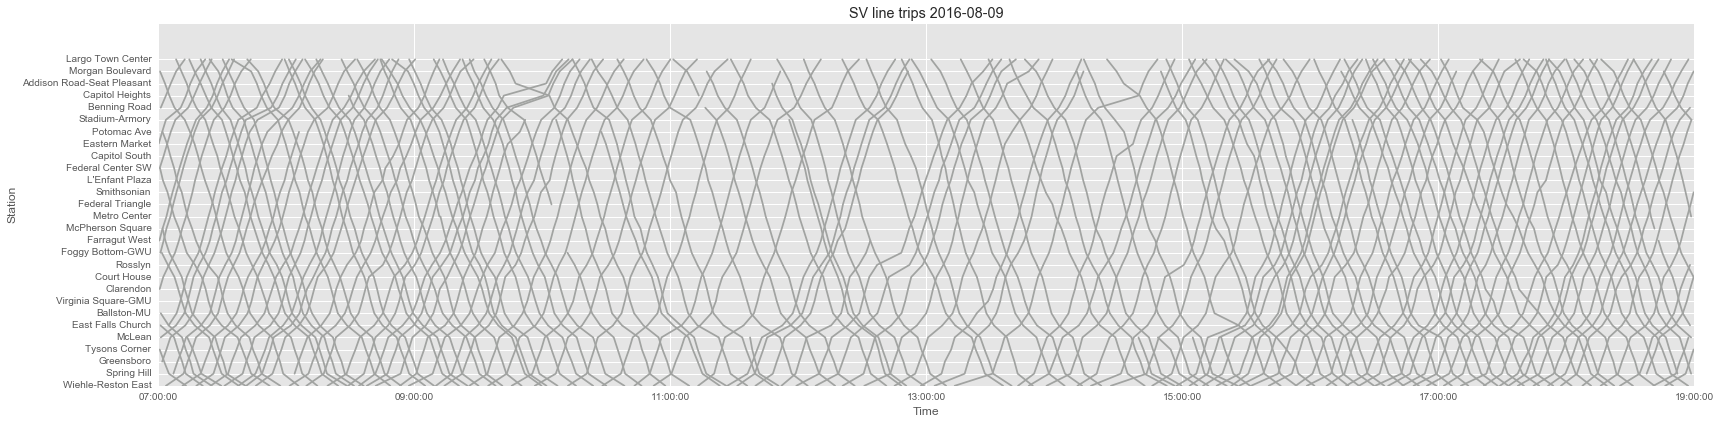

In [3]:
day = 9
month = 8
start_dt = datetime.datetime(2016, month, day, 7)
end_dt = datetime.datetime(2016, month, day, 19)
line_code = 'SV'
plot_trips(df, line_code, start_dt, end_dt)
plt.savefig('{}_{}.png'.format(line_code, start_dt.strftime('%Y-%m-%d')))

/Users/keith/.virtualenvs/notebooks/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


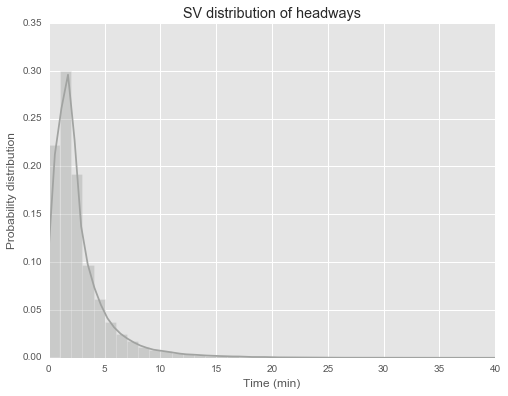

In [4]:
# Distribution of headways   
start = datetime.time(hour=7)
end = datetime.time(hour=19)
diffs = get_time_diffs(df, line_code, start, end)

#convert diffs to minutes
diffs = diffs/np.timedelta64(1, 'm')

plt.figure(figsize=(8, 6))
sns.distplot(diffs, bins=range(0,61), color=line_color_map[line_code], kde_kws={"bw": 1, "kernel": "biw", 'gridsize': 200})
plt.xlim([0, 40])
plt.title("{} distribution of headways".format(line_code))
plt.xlabel('Time (min)')
plt.ylabel('Probability distribution')
plt.savefig('{}_headways.png'.format(line_code))


/Users/keith/.virtualenvs/notebooks/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


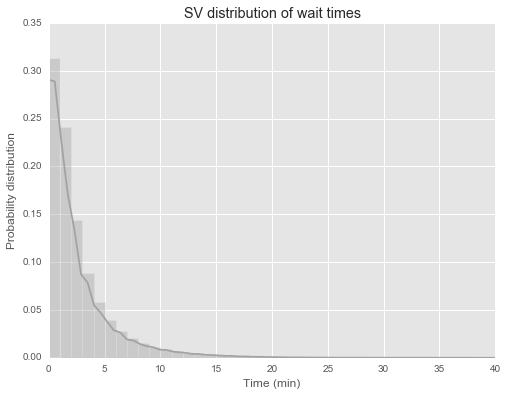

In [5]:
# waiting times
waits = list(itertools.chain(*[np.arange(0, diff, 1).tolist() for diff in diffs]))
#waits
plt.figure(figsize=(8, 6))
sns.distplot(waits, bins=range(0,61), color=line_color_map[line_code], kde_kws={"bw": 1, "kernel": "biw", 'gridsize': 200})
plt.xlim([0, 40])
plt.title("{} distribution of wait times".format(line_code))
plt.xlabel('Time (min)')
plt.ylabel('Probability distribution')
plt.savefig('{}_wait_times.png'.format(line_code))


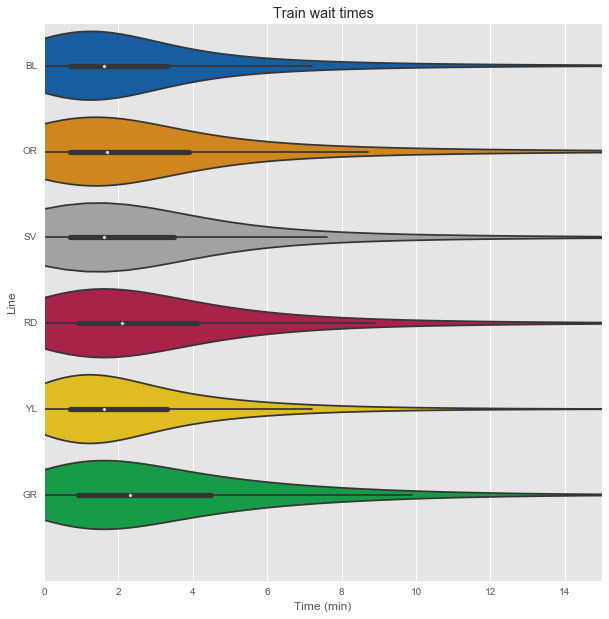

In [6]:
# violin plots of wait times
w = []
for line_code in line_codes:
    diffs = get_time_diffs(df, line_code, start, end)

    #convert diffs to minutes
    diffs = diffs/np.timedelta64(1, 'm')
    waits = list(itertools.chain(*[np.arange(0, diff, 0.1).tolist() for diff in diffs]))
    w.append(waits)

plt.figure(figsize=(10, 10))
sns.violinplot(data=w, orient='h', palette=[line_color_map[l] for l in line_codes],
              scale="width", bw=0.5, cut=0, gridsize=200)
plt.yticks(list(range(0,7)), line_codes)
plt.xlim([0, 15])
plt.title('Train wait times')
plt.xlabel('Time (min)')
plt.ylabel('Line')
plt.savefig('wait_times_max15.png')

BL True
BL False
OR True
OR False
SV True
SV False
RD True
RD False
YL True
YL False
GR True
GR False


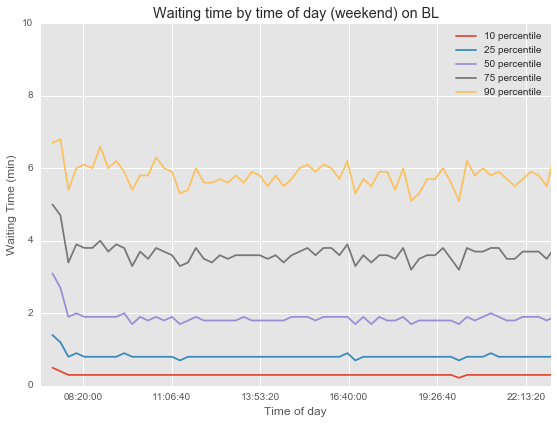

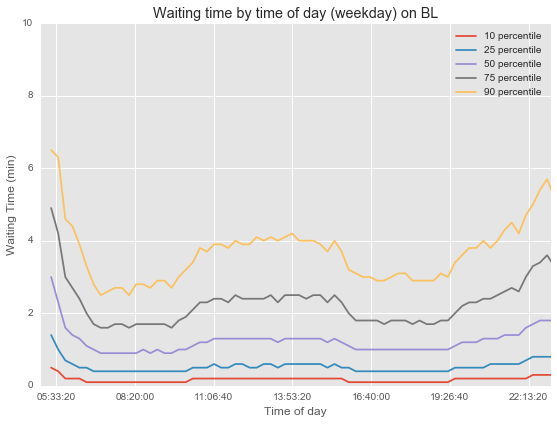

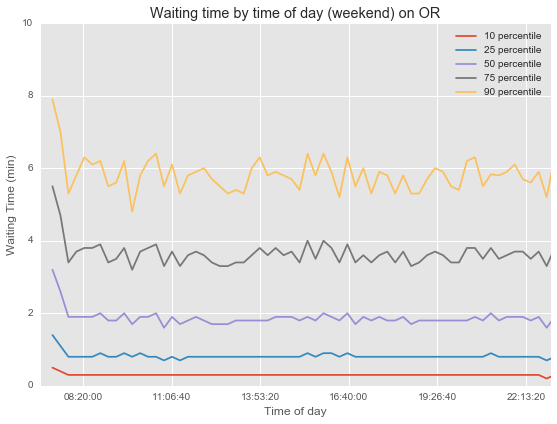

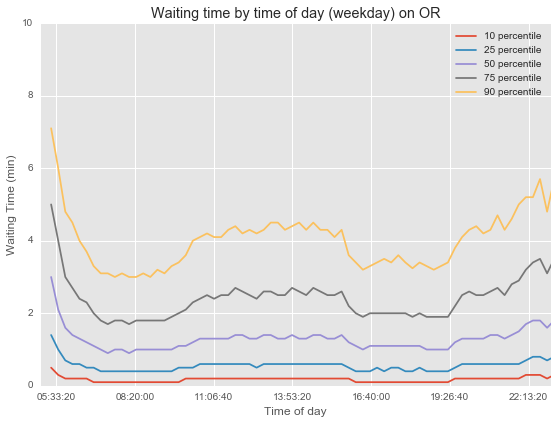

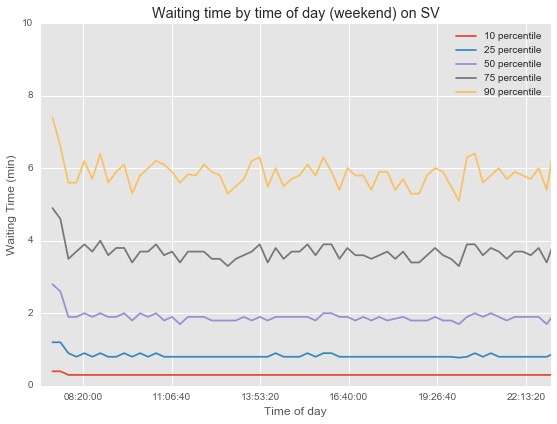

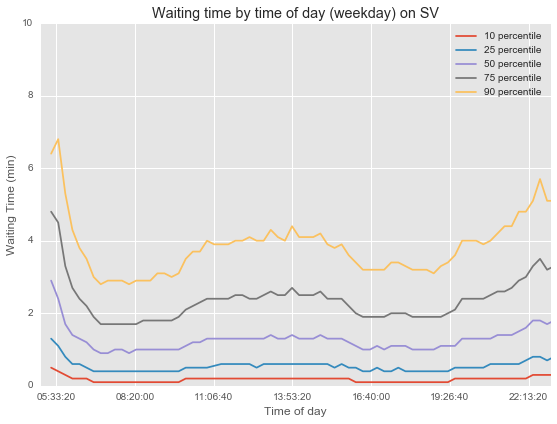

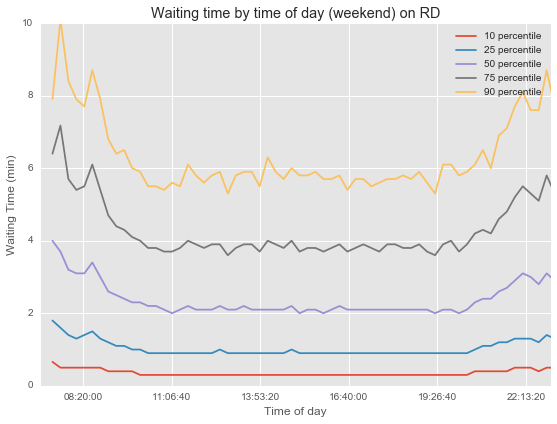

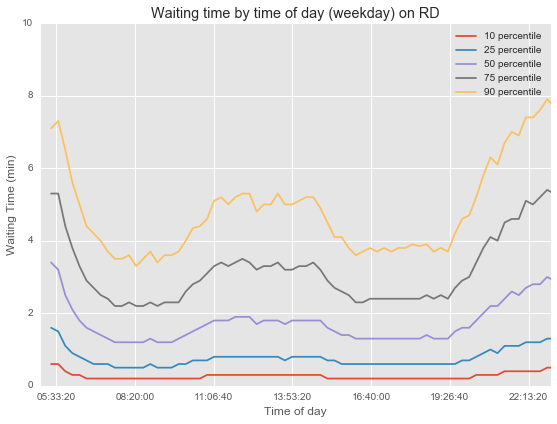

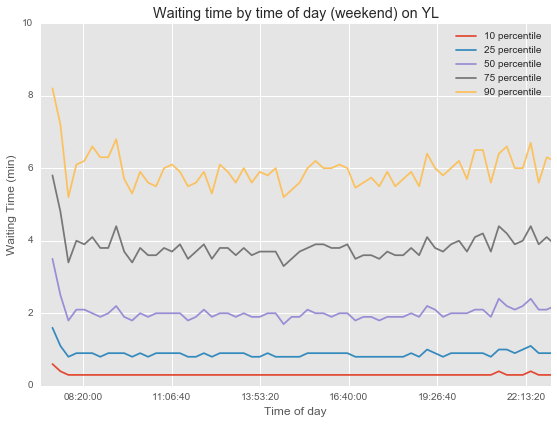

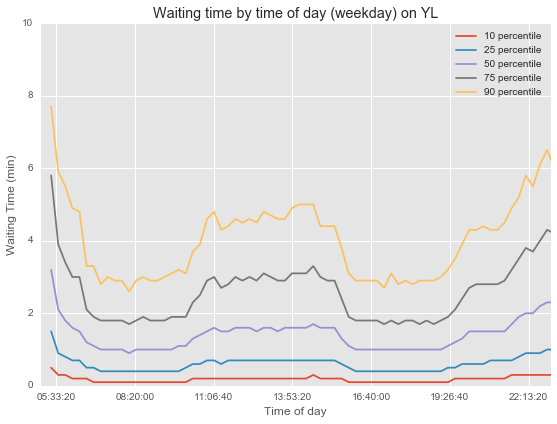

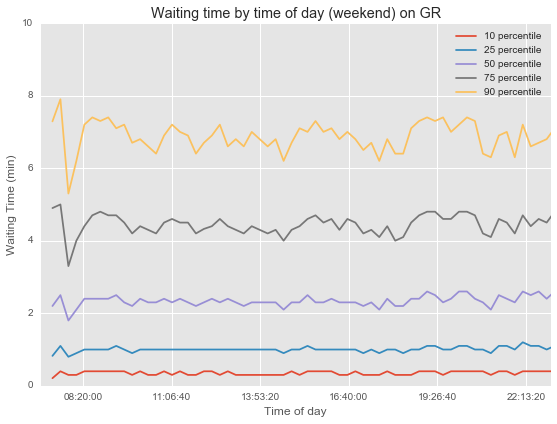

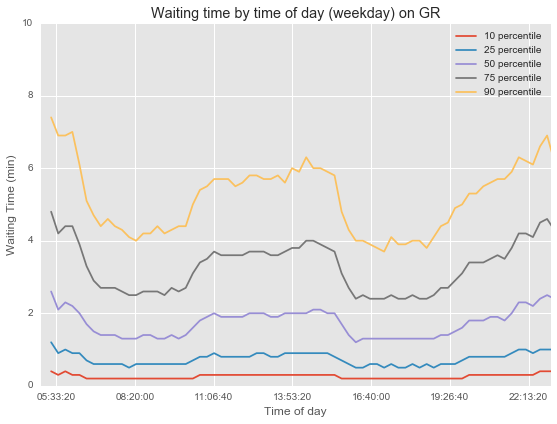

In [7]:
def plot_waits_by_time(df, line_code, weekend=False):
    # first lets get only week days
    dates = pd.DatetimeIndex(df['Date'])
    weekday = dates.weekday
    df['Weekday'] = pd.Series(weekday)
    if weekend:
        dd = df[df['Weekday'] >= 5]
        min_t = 7
    else:
        dd = df[df['Weekday'] < 5]
        min_t = 5
    
    step_size = 0.25 # 15 min
    max_t = 23
    n_steps = int((max_t - min_t) / step_size)
    start = datetime.time(hour=min_t)
    end = (datetime.datetime.combine(datetime.datetime.today(), start) + datetime.timedelta(hours=step_size)).time()
    mid = (datetime.datetime.combine(datetime.datetime.today(), start) + datetime.timedelta(hours=step_size/2)).time()
    
    dists = []
    mids = []
    percentiles = [10, 25, 50, 75, 90]

    for t1 in range(n_steps):
        
        diffs = get_time_diffs(dd, line_code, start, end)

        # convert diffs to mins
        diffs = diffs/np.timedelta64(1, 'm')

        # waiting times
        waits = list(itertools.chain(*[np.arange(0, diff, 0.1).tolist() for diff in diffs]))
        
        # now that we have the waiting times by time of day, we can get their distributions
        data_dist = [np.percentile(waits, percentile) for percentile in percentiles]
        
        start = end
        #end = start + datetime.timedelta(hours=step_size)
        end = (datetime.datetime.combine(datetime.datetime.today(), start) + datetime.timedelta(hours=step_size)).time()
        mid = (datetime.datetime.combine(datetime.datetime.today(), start) + datetime.timedelta(hours=step_size/2)).time()

        dists.append(data_dist)
        mids.append(mid)
        #print(data_dist)
    
    plt.figure(figsize=(8,6))
    plt.title('Waiting time by time of day ({}) on {}'.format("weekend" if weekend else "weekday", line_code))
    plt.xlabel('Time of day')
    plt.ylabel('Waiting Time (min)')
    plt.tight_layout()
    plt.plot(mids, dists)
    plt.legend(["{} percentile".format(p) for p in percentiles])
    plt.xlim(datetime.time(hour=min_t), datetime.time(hour=max_t))
    plt.ylim(0,10)
    plt.savefig("{}_{}_waiting_by_time".format(line_code, "weekend" if weekend else "weekday"))


    

for line_code in line_codes:
    for weekend in [True, False]:
        print(line_code, weekend)
        plot_waits_by_time(df,line_code, weekend=weekend)

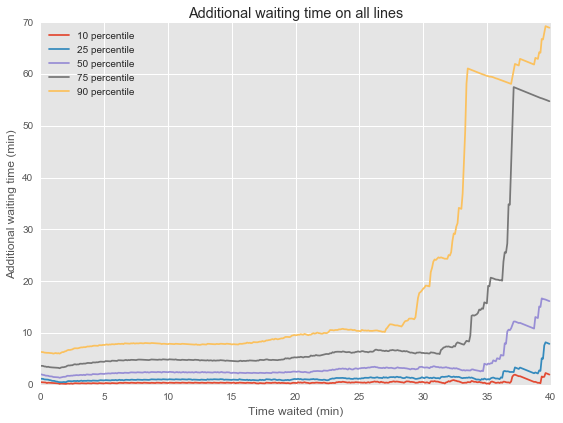

In [8]:
def plot_additional_waits(df):
    percentiles = [10, 25, 50, 75, 90]
    already_waited = np.arange(0,40,0.1).tolist()
    additional_list = []
    # get the amount of time until the next train
    start = datetime.time(hour=7)
    end = datetime.time(hour=19)
    dl = []
    for line_code in line_codes:
        dl.append(get_time_diffs(df, line_code, start, end))

    diffs = pd.concat(dl, axis=0, ignore_index=True)
    #convert diffs to minutes
    diffs = diffs/np.timedelta64(1, 'm')
    for t in already_waited:

        additional_wait_time = [diff - t for diff in diffs if diff>=t]
        additional_percentiles = np.percentile(additional_wait_time, percentiles)
        additional_list.append(additional_percentiles)

    plt.figure(figsize=(8,6))
    plt.title('Additional waiting time on all lines')
    plt.xlabel('Time waited (min)')
    plt.ylabel('Additional waiting time (min)')
    plt.tight_layout()
    plt.plot(already_waited, additional_list)
    plt.legend(["{} percentile".format(p) for p in percentiles], loc=2)
    plt.savefig("additional_waiting_time.png")


plot_additional_waits(df)